In [1]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.transient_models.afterglow_models import tophat, tophat_redback
from sklearn import preprocessing as pre
import scipy.constants as const
from sklearn.model_selection import GridSearchCV
import random
import pickle
from scipy import interpolate

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [94]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [95]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [96]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [97]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

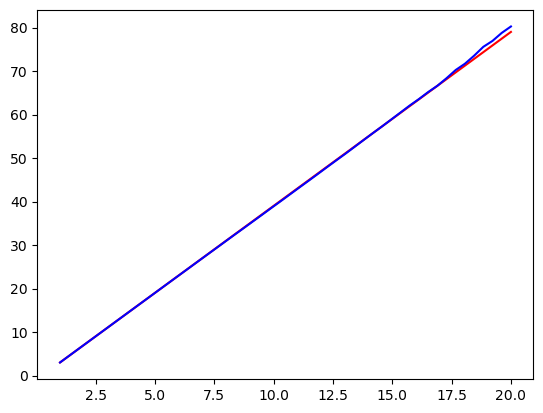

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [2]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [3]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [2]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=10000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)

NameError: name 'afterglow_constraints' is not defined

In [269]:
time = np.linspace(0.1, 300, 600) #xs
yvals = np.zeros((num, len(time)))  #ys

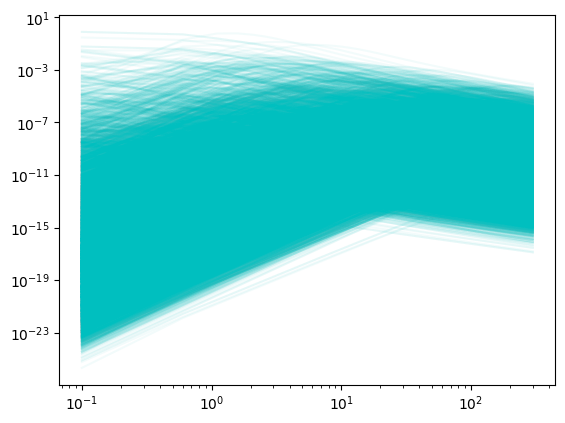

In [270]:
ax= plt.subplot()

for i in range(num):
    yvals[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, yvals[i], color='c', alpha=0.05)
plt.show()

In [290]:
X = afterglow_data.values
Y = yvals
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='sgd', learning_rate='adaptive').fit(X, Y)

In [291]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 600)

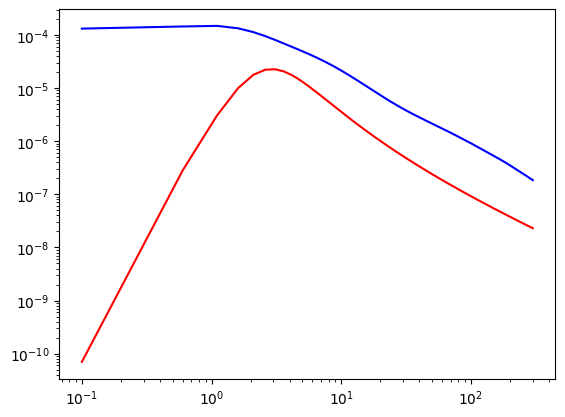

In [292]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue')#, ls='None', marker='x')
plt.show()

In [3]:
def tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=1, g0=g0, frequency= frequency)
    return flux

In [2]:

def new_tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat_redback(time=time, output_format='flux_density', redshift=0.01, steps=1000, thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, xiN=1, g0=g0, frequency= frequency)
    return flux

In [12]:
general_priors= redback.priors.get_priors(model='tophat_redback')
#general_priors['frequency']= Uniform(minimum=1e13, maximum=2e15, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
frequency=[]
"""
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),10000))
    frequency.extend(rand_samples)
"""
frequency=np.ones(10000)*3.45e14
random.shuffle(frequency)
num=10000
tnum=1000
samples=general_priors.sample(num)
samples['frequency']=frequency
tophat_data=pd.DataFrame.from_dict(samples)
unprocessed= pd.DataFrame.from_dict(samples)
tophat_data.drop('redshift', axis=1,inplace=True)
tophat_data.drop('xiN', axis=1,inplace=True)
unprocessed.drop('redshift', axis=1,inplace=True)
unprocessed.drop('xiN', axis=1,inplace=True)

tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

min(unprocessed['frequency'])

345000000000000.0

In [13]:
tophat_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,0.086591,50.955687,-1.333852,1.755815,2.333456,-4.797587,-0.158102,3.039636,14.537819
1,0.179833,51.403834,-1.045982,-1.142548,2.675037,-1.014604,-1.517388,3.258801,14.537819
2,-0.257829,44.309746,-1.218780,-3.856583,2.591953,-2.813353,-0.619527,3.264514,14.537819
3,0.153122,49.184696,-1.306557,-1.227262,2.172978,-4.704169,-1.905943,2.841403,14.537819
4,0.043735,53.726094,-1.879590,-3.050241,2.764401,-4.040364,-1.791331,2.883570,14.537819
...,...,...,...,...,...,...,...,...,...
9995,0.153766,52.276302,-1.762236,0.388943,2.061816,-1.472824,-1.433491,3.183528,14.537819
9996,-0.083488,46.464124,-1.789528,-3.170398,2.109459,-4.102287,-4.458078,2.981767,14.537819
9997,-0.046928,47.863865,-1.554949,-1.404896,2.277148,-4.039696,-4.990257,2.818195,14.537819
9998,0.101652,53.540732,-1.309848,-3.710783,2.254224,-3.748299,-2.693261,2.918713,14.537819


In [24]:
def axis_spec(parameters):
    constrained_params= parameters.copy()

    #thv-thc for off axis, thc-thv for on axis
    constrained_params['alignment']=  parameters['thc']-parameters['thv']
    return constrained_params

In [25]:
priors = PriorDict(conversion_function=axis_spec)
priors['alignment']= Constraint(minimum=0, maximum=1.57)
priors.update(redback.priors.get_priors(model='tophat_redback'))
priors.pop('redshift')
priors.pop('xiN')
priors

{'alignment': Constraint(minimum=0, maximum=1.57, name=None, latex_label=None, unit=None),
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}~\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}~\\epsilon_{B}$', unit=None, b

In [26]:
onax_samples=priors.sample(36000)
frequency=[]
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),4000))
    frequency.extend(rand_samples)
random.shuffle(frequency)
onax_samples['frequency']=frequency
onax_data=pd.DataFrame.from_dict(onax_samples)
onax_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,0.026898,47.693297,0.042723,0.841995,2.591597,-3.810478,-0.168392,891.779215,805445615360
1,0.004734,45.072319,0.046987,-2.152964,2.394943,-3.614775,-1.780236,1772.595075,16513747164
2,0.065081,49.507716,0.097941,-0.387262,2.560232,-2.572989,-3.550983,745.186285,26401290916039541
3,0.039225,48.555892,0.090720,-2.588781,2.425158,-4.884841,-3.389953,1218.496497,1267130761
4,0.044080,44.381135,0.068125,1.330727,2.416799,-2.744971,-0.579041,1487.371759,37123880294528
...,...,...,...,...,...,...,...,...,...
35995,0.079947,52.357804,0.089936,-1.096353,2.490149,-3.632066,-2.042306,1718.948277,1016466861187
35996,0.081458,49.344973,0.082906,-1.000804,2.494383,-4.859371,-4.422771,499.609193,87616430263879
35997,0.071737,46.058127,0.086804,-1.440444,2.105366,-3.358968,-4.134601,816.779162,945589233777969476
35998,0.050396,50.199974,0.080755,-1.603893,2.303281,-1.466179,-0.870483,1922.630665,8602028888677


In [23]:
offax_samples=priors.sample(81000)
frequency=[]
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),9000))
    frequency.extend(rand_samples)
random.shuffle(frequency)
offax_samples['frequency']=frequency
offax_data=pd.DataFrame.from_dict(offax_samples)
offax_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,1.502916,45.648086,0.090967,-0.600873,2.718093,-4.209601,-4.293633,1764.426622,11825674442
1,1.196006,53.909057,0.014601,-3.977400,2.904718,-2.061406,-0.843865,1069.470176,199801135919199677
2,1.105102,52.189213,0.043677,1.007844,2.560815,-2.739554,-1.864501,1423.779696,90824852094903
3,1.289204,47.124765,0.041269,-2.324037,2.768757,-1.396918,-3.023043,1226.322601,44795269343851532
4,0.375913,47.759065,0.062786,-2.695426,2.946889,-0.572611,-0.141959,1694.588746,3664997757
...,...,...,...,...,...,...,...,...,...
80995,1.147943,51.425738,0.035942,-1.442720,2.099911,-3.720270,-2.472568,1046.820114,718868645341
80996,0.658484,48.177671,0.062627,-4.731670,2.158290,-1.379525,-3.975611,1787.971552,7585594094
80997,0.426660,47.115433,0.085718,-0.677363,2.414133,-4.696805,-1.236138,366.767424,567200787209
80998,0.722297,50.761874,0.093050,-1.985036,2.880131,-2.543573,-3.771884,479.125086,966414208099128


In [27]:
unprocessed= pd.concat([onax_data,offax_data], ignore_index=True)
unprocessed= unprocessed.sample(frac=1).reset_index(drop=True)
tophat_data= unprocessed.copy()
tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

In [28]:
36000+81000

117000

In [29]:
num=117000
tnum=5000
training = tophat_data.iloc[:(num-tnum)]
testing = tophat_data.iloc[(num-tnum):]


In [30]:
testing

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
112000,-0.296577,44.200137,-1.437040,0.885938,2.007517,-4.918217,-1.912632,2.740770,11.898928
112001,0.077428,50.273503,-1.099680,-0.296057,2.150049,-2.550802,-3.652662,3.021647,13.482253
112002,-1.195165,48.405101,-1.084192,-0.822550,2.250225,-2.358966,-3.281045,2.881048,17.413364
112003,-1.331281,50.197113,-1.237188,0.086809,2.909206,-2.405603,-1.829364,3.043238,9.201834
112004,-0.491894,45.821201,-1.278436,-0.826546,2.198697,-0.800544,-1.599926,3.034756,11.456514
...,...,...,...,...,...,...,...,...,...
116995,0.149203,48.406156,-1.213967,-2.729841,2.427474,-2.756667,-2.956961,2.802968,16.985908
116996,0.062449,45.731435,-1.196885,-2.923070,2.195478,-1.899585,-4.721136,2.874530,12.803393
116997,-1.150549,49.930813,-1.005498,-0.271519,2.806820,-4.005405,-3.788801,3.138904,9.626115
116998,-0.089455,51.602810,-1.219424,1.491030,2.389370,-1.038345,-2.315072,3.110487,14.620568


In [6]:
#original
time = np.linspace(0.1, 1, 10)
time=np.insert(time,10,np.linspace(1.2,10,20))
time=np.insert(time,30,np.linspace(12,300,70))

In [83]:
#lower res
time = np.linspace(0.1, 1, 5)
time=np.insert(time,5,np.linspace(1.2,10,15))
time=np.insert(time,20,np.linspace(12,300,40))

In [107]:
#highres1
time2= np.linspace(0.1,1,10)
time2=np.insert(time2,10,np.linspace(1.2,10,20))
time2=np.insert(time2,30,np.linspace(12,300,170))

In [73]:
time5= np.linspace(0.1,1,5)
time5=np.insert(time3,5,np.linspace(1.2,10,15))
time5=np.insert(time3,20,np.linspace(12,50,30))
time5=np.insert(time3,50,np.linspace(52,300,50))


In [85]:
#bad result
time3= np.linspace(0.1,1,3)
time3=np.insert(time3,3,np.linspace(1.2,10,12))
time3=np.insert(time3,15,np.linspace(12,100,75))
time3=np.insert(time3,90,np.linspace(100,300,110))

In [97]:
#highres_tophat_redback2
time4= np.linspace(0.1,1,5)
time4=np.insert(time4,5,np.linspace(1.2,10,15))
time4=np.insert(time4,20,np.linspace(12,100,50))
time4=np.insert(time4,70,np.linspace(102,300,80))

In [31]:
logtime= np.logspace(3.94,7.41,100)/86400

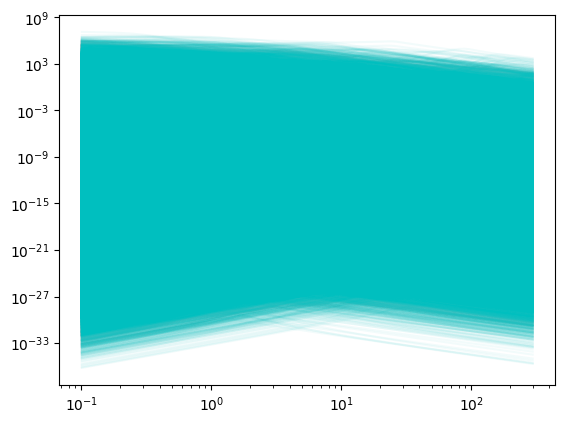

In [32]:
#time = np.linspace(0.1, 300, 150) #xs
ys = np.zeros((num-tnum, len(logtime)))  #ys

ax= plt.subplot()

for i in range(num-tnum):
    ys[i]= new_tophat_func(logtime, **unprocessed.iloc[i])
    ax.loglog(logtime, ys[i], color='c', alpha=0.05)
plt.show()

In [75]:
ys=np.load('yvals.npy')
ys.shape

FileNotFoundError: [Errno 2] No such file or directory: 'yvals.npy'

In [71]:
#tophat_redback model score with test values
X= scalerx.transform(testing.values)
Y= scalery.transform(np.log10(ys))
model.score(X,Y)

ValueError: X has 150 features, but StandardScaler is expecting 100 features as input.

In [33]:
scalerx = pre.StandardScaler()
scalery = pre.StandardScaler()
Y_train = scalery.fit_transform(np.log10(ys))
X_train = scalerx.fit_transform(training.values)
X_test= scalerx.transform(testing.values)

#params=np.array([0.5, 50.0 , 0.02, 1, 2.13,-1.25,-2.5, 1000])
#prediction = regr.predict(params.reshape(1,-1))


In [34]:
regressor = MLPRegressor(random_state=7, max_iter=1000, hidden_layer_sizes=(800), activation='relu',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-3, batch_size=128, early_stopping=True, alpha=0.1).fit(X_train, Y_train)

In [35]:
regressor.best_validation_score_

0.9989688135018526

In [87]:
regressor.n_iter_

44

In [36]:
prediction = regressor.predict(X_test)
prediction = 10**(scalery.inverse_transform(prediction))

testys= np.zeros((tnum, len(logtime)))
for i in range(tnum):
    testys[i]= new_tophat_func(logtime, **unprocessed.iloc[(num-tnum)+i])

X= scalerx.transform(testing.values)
Y= scalery.transform(np.log10(testys))
regressor.score(X,Y)

0.9988882644878424

time original
0.9992 for 1000x1

time lower res
0.9991

time4 100 test samples
0.9987 for 300x3 
0.9992 for 500x2

time5 100 test samples
0.9991 for 500x2

time3 1000 test samples
0.9986 for 500x2

logtime (100pts) 1000 test samples
0.9984 for 500x2
0.9990 for 500x3
0.9991 for 1000x1

logtime(50pts) 1000 test samples
0.9992 for 500x2
0.9988 for 500x1
0.9988 for 300x3
0.9990 for 300x2
0.9992 for 800x1 -smoother
0.9993 for 800x2
0.9992 for 1000x1

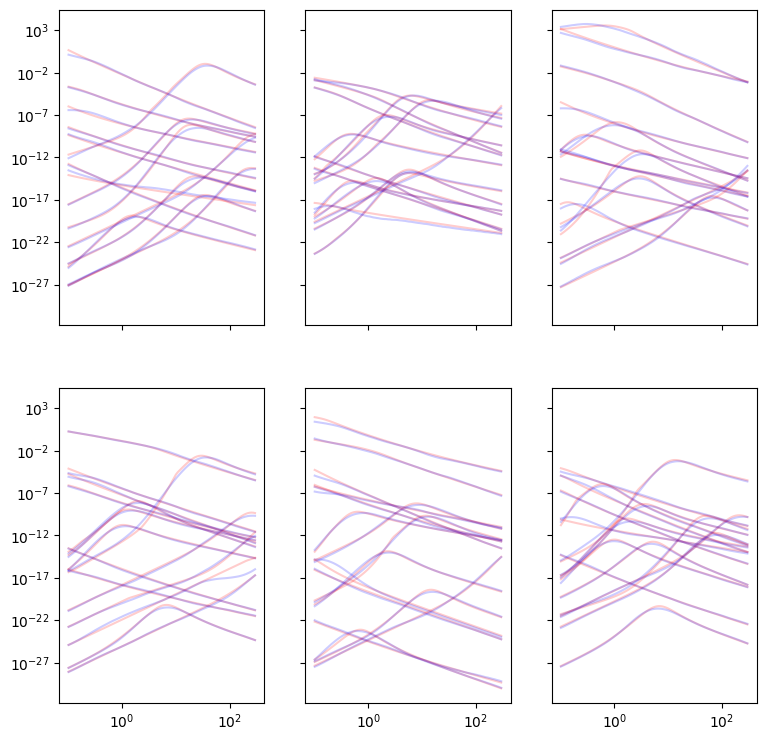

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,9), sharex=True, sharey=True)
#time = np.linspace(0.1, 300, 150) #xs
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)

for i in range(15): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,0].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,0].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(15,30): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,1].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,1].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(30,45): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,0].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,0].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(45,60): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,1].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,1].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(60,75): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,2].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,2].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(75,90): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,2].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,2].loglog(logtime, prediction[i], color='blue', alpha=0.2)

#true_value= tophat_func(time, **unprocessed.iloc[2+(num-tnum)])
#ax[0,0].loglog(time, true_value, color='red', alpha=0.5)
#plt.savefig("emulation_final.png", dpi='figure')
plt.show()

In [11]:
with open("tophat.pkl", "wb") as f:
    pickle.dump(regr, f)

In [38]:
with open("final_tophat_redback.pkl", "wb") as file:
    pickle.dump(regressor, file)

In [39]:
with open("final_scalery.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("final_scalerx.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [33]:
with open("new_scalery.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("new_scalerx.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [69]:
params={}
params['thv']= np.log10(0.07)
params['loge0'] = 51.5
params['thc'] = np.log10(0.09)
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = np.log10(1000)
params['frequency']=np.log10(3.45e14)
test=np.fromiter(params.values(),dtype=float).reshape(1,-1)

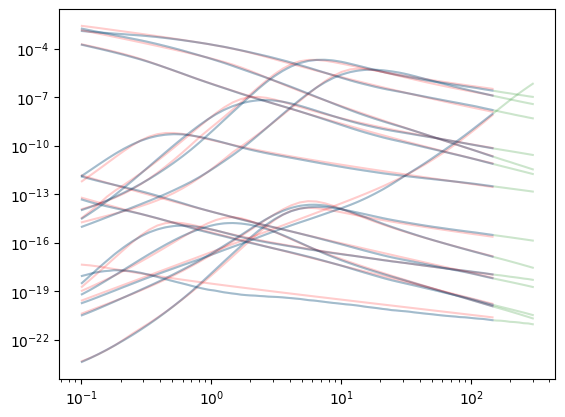

In [43]:
#time=np.linspace(0.1,300,150)
'''
with open("tophat_redback.pkl", "rb") as f:
    model = pickle.load(f)
with open("scalery_redback.pkl", "rb") as sy:
    scalery = pickle.load(sy)
with open("scalerx_redback.pkl", "rb") as sx:
    scalerx = pickle.load(sx) 
'''
xtests= scalerx.transform(testing.values)
prediction= regressor.predict(xtests)
prediction = 10**(scalery.inverse_transform(prediction))
#print(model.score(xtests,scalery.transform(np.log10(ys))))
afterglow = interpolate.interp1d(logtime, prediction, kind='linear')
new_time= np.linspace(0.11,40,200)
new_time= np.logspace(3.94,7.1,50)/86400

fluxd= afterglow(new_time)

ax=plt.subplot()
for i in range(15,30):
    true_value= new_tophat_func(new_time, **unprocessed.iloc[i+(num-tnum)])
    #print(unprocessed.iloc[i+(num-tnum)])
    ax.loglog(new_time, true_value, color='red', alpha=0.2)#, marker='o', markersize=2)#actual function with 'interpolated time'
    ax.loglog(new_time, fluxd[i], color='blue', alpha=0.2)#, marker='o', markersize=2) #predicted by emulator with interpolation
    ax.loglog(logtime, prediction[i], color='green', alpha=0.2)#, marker='o', markersize=2) #prediction emulator no interpolation
#true_value= new_tophat_func(new_time, **unprocessed.iloc[19+(num-tnum)])
#ax.loglog(new_time, true_value, color='purple', alpha=0.2)
plt.show()

In [154]:
unprocessed.iloc[19+num-tnum]

thv          1.473825e-01
loge0        5.260471e+01
thc          7.948577e-02
logn0       -7.455978e-01
p            2.142358e+00
logepse     -1.833241e+00
logepsb     -3.297658e+00
g0           3.347162e+02
frequency    3.450000e+14
Name: 9019, dtype: float64

In [147]:
true_value= new_tophat_func(new_time, **unprocessed.iloc[15+(num-tnum)])
ax.loglog(new_time, true_value, color='purple', alpha=0.2)
plt.show()

In [65]:
len(prediction)

1000

In [21]:
np.log10(300*86400)

7.413634997198556

In [16]:
new_time= np.logspace(0.1,1.5,50)/86400
print(new_time)

[1.45708960e-05 1.55617232e-05 1.66199271e-05 1.77500893e-05
 1.89571031e-05 2.02461943e-05 2.16229443e-05 2.30933138e-05
 2.46636692e-05 2.63408093e-05 2.81319958e-05 3.00449836e-05
 3.20880555e-05 3.42700572e-05 3.66004359e-05 3.90892814e-05
 4.17473694e-05 4.45862086e-05 4.76180900e-05 5.08561407e-05
 5.43143803e-05 5.80077817e-05 6.19523359e-05 6.61651215e-05
 7.06643784e-05 7.54695867e-05 8.06015513e-05 8.60824916e-05
 9.19361383e-05 9.81878354e-05 1.04864651e-04 1.11995492e-04
 1.19611234e-04 1.27744850e-04 1.36431555e-04 1.45708960e-04
 1.55617232e-04 1.66199271e-04 1.77500893e-04 1.89571031e-04
 2.02461943e-04 2.16229443e-04 2.30933138e-04 2.46636692e-04
 2.63408093e-04 2.81319958e-04 3.00449836e-04 3.20880555e-04
 3.42700572e-04 3.66004359e-04]


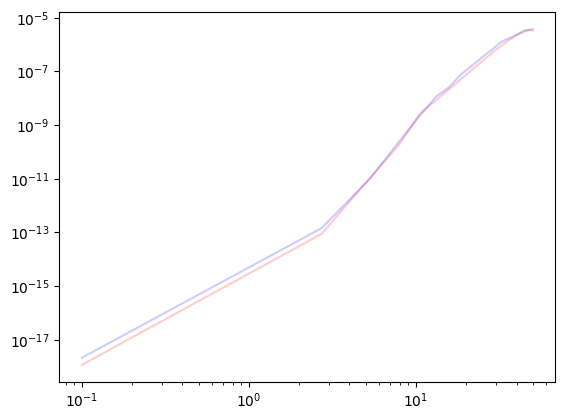

In [8]:
new_time= np.linspace(0.1,50,20)
fluxd= afterglow(new_time)

ax=plt.subplot()
for i in range(1,2):
    true_value= new_tophat_func(new_time, **unprocessed.iloc[i+(num-tnum)])
    ax.loglog(new_time, true_value, color='red', alpha=0.2)
    ax.loglog(new_time, fluxd[i], color='blue', alpha=0.2)
plt.show()

In [116]:
prediction.shape

(100, 100)

In [ ]:
for i in range(10):
    plt.plot(time, ys)
    plt.plot(time, new_tophat_func(time,xtests[i]))

In [63]:
prediction.shape

(100, 100)

In [7]:
fluxd.shape

(100, 50)

In [15]:
prediction.shape

(100, 150)

In [21]:
xtests.shape

(100, 9)

In [38]:
unprocessed.iloc[2+(num-tnum)]

thv          1.122384e+00
loge0        5.159928e+01
thc          1.529868e-02
logn0       -1.734760e+00
p            2.967152e+00
logepse     -3.121768e-01
logepsb     -6.179132e-01
g0           5.168700e+02
frequency    6.516236e+14
Name: 79902, dtype: float64

In [39]:
unprocessed.iloc[11+(num-tnum)]

thv          6.543900e-02
loge0        4.983819e+01
thc          2.080898e-02
logn0       -3.140924e+00
p            2.251693e+00
logepse     -3.730114e+00
logepsb     -3.953608e+00
g0           2.132696e+02
frequency    3.087617e+17
Name: 79911, dtype: float64

In [75]:
unprocessed['frequency'].iloc[num-tnum:].values

array([1.00656140e+14, 1.06020086e+15, 1.29688986e+15, 1.12992999e+15,
       4.47437220e+14, 1.93297609e+15, 7.56629244e+14, 9.70446701e+14,
       1.17409372e+15, 1.41467503e+14, 4.49154818e+13, 7.81176125e+14,
       1.66962403e+15, 1.04042828e+15, 2.82502902e+14, 1.59135245e+15,
       1.80573842e+15, 1.26905363e+15, 1.26559804e+15, 1.52777522e+15,
       1.19898263e+15, 6.07214871e+14, 6.64438092e+14, 1.87507081e+15,
       2.52054190e+13, 3.56368518e+14, 1.29395306e+15, 4.69968628e+14,
       1.28224333e+15, 6.25654261e+14, 1.03705093e+14, 9.67024739e+14,
       1.24829321e+15, 1.94731382e+14, 1.24752724e+15, 7.51019582e+14,
       2.12234999e+14, 1.98934120e+15, 1.62828601e+15, 1.69866155e+14,
       4.20091907e+13, 1.41625790e+15, 1.71859143e+15, 1.50969322e+15,
       1.56926946e+15, 1.16343556e+15, 4.51808285e+14, 1.97380320e+14,
       3.56269372e+14, 1.60267180e+15, 9.03281048e+14, 1.46055184e+15,
       1.54683553e+15, 1.28757302e+15, 1.33752192e+14, 4.20890107e+14,
      

In [73]:
print(regr.n_iter_, regr.best_loss_)

73 0.005612029467075825


In [11]:
print(regr.n_iter_, regr.best_loss_)

38 0.0013669637969929973


In [14]:
print(regr.n_iter_, regr.best_loss_, regr.t_)

10 0.0014232664780402901 999000


In [15]:
param_grid={}
param_grid['hidden_layer_sizes']=[(500,500,500), (800,800,800)]
param_grid['activation']=['relu','tanh']
param_grid['solver']=['adam','sgd']
param_grid['batch_size']=[64,128]
param_grid['learning_rate_init']=[0.001]

In [17]:
mlp = MLPRegressor(random_state=7, max_iter=1000, learning_rate_init=0.001, batch_size='auto')
tuner = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=3, pre_dispatch=3)
tuner.fit(X_train,Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [20]:
tuner.best_score_

0.9987270022686235

In [19]:
tuner.best_params_

{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_sizes': (800, 800, 800),
 'learning_rate_init': 0.0001,
 'solver': 'adam'}

In [76]:
def power(frequency, g0, logepsb, logn0):
    me= const.m_e
    mp= const.m_p
    c= const.c
    sigma = const.sigma
    q=const.e
    n0= 10**(logn0)
    epsb= 10**(logepsb)
    constant = (me*(c**3)*sigma*((32*np.pi*mp)**0.5))/(3*q)

    pow= constant*(g0**2)*((epsb*n0)**0.5)*frequency*10e7 #power in ergs
    return pow

In [77]:
pprior = bilby.core.prior.PriorDict()
pprior['g0'] = bilby.core.prior.Uniform(100, 2000, 'g0')
pprior['logepsb'] = bilby.core.prior.Uniform(-5, 0, 'c')
pprior['logn0']=bilby.core.prior.Uniform(-5,2,'logn0')
pprior

{'g0': Uniform(minimum=100, maximum=2000, name='g0', latex_label='g0', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='c', latex_label='c', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='logn0', unit=None, boundary=None)}

In [78]:
N= 5000
samples=pprior.sample(N)
power_data=pd.DataFrame.from_dict(samples)
power_data

,g0,logepsb,logn0
0,185.380307,-2.711978,0.601665
1,1423.031101,-4.650265,1.992532
2,394.884171,-0.541732,-1.991962
3,1221.158402,-4.845642,1.404221
4,415.062706,-3.860507,-4.259996
...,...,...,...
4995,944.116862,-2.469384,-2.699051
4996,1360.925225,-1.993366,0.738621
4997,959.389273,-3.519324,1.084934
4998,797.601144,-0.752727,-0.088104


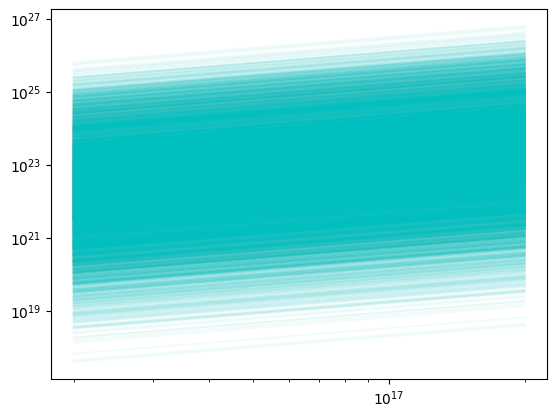

In [188]:
frequency = np.linspace(2e16, 2e17, 500) #xs
y = np.zeros((4900, len(frequency)))  #ys  

ax= plt.subplot()
for i in range(4900):
    y[i]= power(frequency, **power_data.iloc[i])
    ax.loglog(frequency, y[i], color='c', alpha=0.05)
plt.show()

In [196]:
y_train= y
scaler = pre.StandardScaler()
x_train=power_data.iloc[:4900].values
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 

x_test=power_data.iloc[4900:].values
x_test = scaler.transform(x_test)

regress = MLPRegressor(random_state=7, max_iter=2000, hidden_layer_sizes=(100,), activation='tanh',solver='sgd',learning_rate='adaptive', 
                       learning_rate_init=1e-5, batch_size= 16).fit(x_train, y_train)

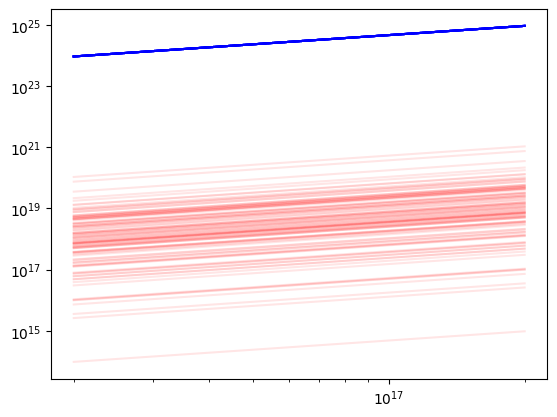

In [197]:
prediction = regress.predict(x_test)
#print(prediction)
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax2=plt.subplot()
for i in range(100): 
    true_value= power(frequency, *x_test[i])
    ax2.loglog(frequency, true_value, color='red', alpha=0.1)
    ax2.loglog(frequency, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
#plt.ylim(10e22,10e25)
plt.show()

In [2]:
from redback.simulate_transients import SimulateGenericTransient
times= np.linspace(0.1,40,100)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}

params={}
params['av'] = 0.5
params['loge0'] = 49.5
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = 1000
params['thv']= 0.5
params['thc'] = 0.06
params['base_model']='tophat_from_emulator'
    
tophatag =  SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)
tophatag.data

[1.952e+14 2.601e+14 3.083e+14 3.454e+14 3.983e+14 4.825e+14 6.273e+14
 8.152e+14 1.141e+15]


,time,frequency,true_output,output,output_error
0,0.100000,2.000000e+17,9.310888e-13,9.655689e-13,4.655444e-14
1,0.100000,3.454000e+14,4.293809e-10,4.552555e-10,2.146905e-11
2,0.503030,5.000000e+09,4.681506e-03,5.094574e-03,2.340753e-04
3,0.503030,2.000000e+17,2.310406e-08,2.361057e-08,1.155203e-09
4,0.906061,2.000000e+17,4.620719e-08,4.410408e-08,2.310360e-09
...,...,...,...,...,...
495,40.000000,5.000000e+09,4.062142e-04,4.473072e-04,2.031071e-05
496,40.000000,6.273000e+14,1.011237e-07,1.007574e-07,5.056185e-09
497,40.000000,1.952000e+14,3.382322e-07,3.651328e-07,1.691161e-08
498,40.000000,2.000000e+17,1.752232e-09,1.769289e-09,8.761158e-11


Meta data does not exist for this event.


[4.10627441e-10 2.61571639e-07 2.28743801e-06 7.09015986e-06
 1.28219993e-05 1.68917857e-05 1.83640209e-05 1.78120805e-05
 1.61653271e-05 1.41510105e-05 1.21482624e-05 1.03507898e-05
 8.81548481e-06 7.53085429e-06 6.46787863e-06 5.59058093e-06
 4.86515860e-06 4.26316000e-06 3.76056890e-06 3.33841656e-06
 2.98151649e-06 2.67765802e-06 2.41742885e-06 2.19312659e-06
 1.99858953e-06 1.82894178e-06 1.68022576e-06 1.54919278e-06
 1.43318434e-06 1.32998131e-06 1.23778634e-06 1.15513330e-06
 1.08077058e-06 1.01361641e-06 9.52732946e-07 8.97382486e-07
 8.46932678e-07 8.00803699e-07 7.58503357e-07 7.19647975e-07
 6.83830318e-07 6.50764561e-07 6.20174260e-07 5.91796907e-07
 5.65453837e-07 5.40912805e-07 5.18044539e-07 4.96674520e-07
 4.76691838e-07 4.57958952e-07 4.40390521e-07 4.23871966e-07
 4.08343170e-07 3.93694850e-07 3.79887463e-07 3.66839550e-07
 3.54502360e-07 3.42823305e-07 3.31748504e-07 3.21250937e-07
 3.11279199e-07 3.01804169e-07 2.92784668e-07 2.84192241e-07
 2.76010037e-07 2.682021

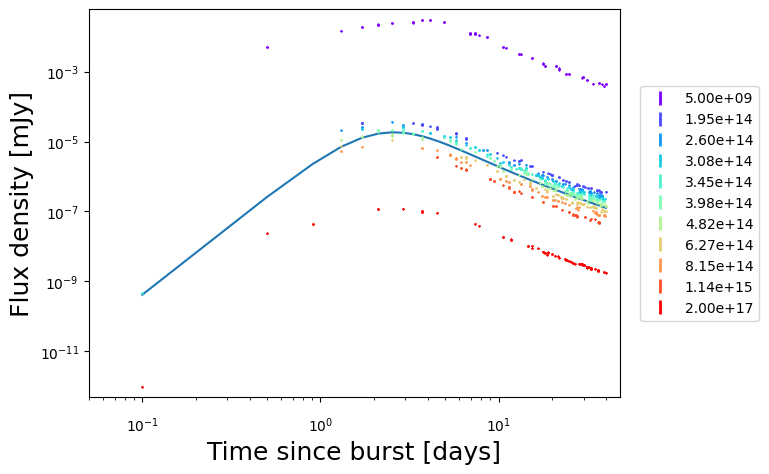

In [3]:
emulator_ag = redback.transient.Afterglow(name='afterglow_emulator', flux_density=tophatag.data['output'].values,
                                      time=tophatag.data['time'].values, data_mode='flux_density',
                                      flux_density_err=tophatag.data['output_error'].values, frequency=tophatag.data['frequency'].values)

ax=emulator_ag.plot_data(show=False)
flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(times, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.5, loge0=49.5 , thc= 0.06, logn0=0.5, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
        output_format='flux_density' , frequency=4.82e14)
print(flux)
ax.loglog(times, flux)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [8]:
model='tophat_from_emulator'
injection_parameters= params
model_kwargs = dict(frequency=emulator_ag.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors('tophat')
priors['redshift']=0.01
priors['ksin']=1
priors

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/encodings/unicode_escape.py:26: DeprecationWarning: invalid escape sequence '\m'
  return codecs.unicode_escape_decode(input, errors, final)


{'redshift': 0.01,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}~\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}~\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': 1,
 'g0': Uniform(minimum=100, maximum=2000, nam

In [ ]:
emulator_result = redback.fit_model(transient=emulator_ag, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)


16:56 bilby INFO    : Running for label 'GRBafterglow_emulator', output will be saved to 'GRBData/afterglow/flux_density//tophat_from_emulator'
16:56 bilby INFO    : Analysis priors:
16:56 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None)
16:56 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None)
16:56 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None)
16:56 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None)
16:56 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
16:56 bilby INFO    : logepse=Uniform(minimum=-5, maximum=0, nam

1it [00:00, ?it/s]

17:08 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
17:18 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
17:18 bilby WARNING